## Сборный проект №1


Интернет-магазинн «Стримчик», продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) по 2016 год включительно. 

**Необходимо:**
1. Выявить определяющие успешность игры закономерности.
2. Отработать принцип работы с данными.
3. Определить потенциально популярный продукт.
4. Спланировать рекламные кампании на 2017 год.


## Шаг 1. Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
from scipy import stats as st

In [ ]:
from datetime import datetime

In [ ]:
import math

In [ ]:
df = pd.read_csv('/datasets/games.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Просуммируем количество пропущенных значений в каждом столбце:

In [ ]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [ ]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [ ]:
df.duplicated().sum()

0

Для анализа предоставлена одна таблица состоящая из 16715 строк и 11 колонок.  

Присутствуют пропуски в 5 столбцах: `Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating`.  

Необходимо изменить форматы в столбцах:
- Year_of_Release - на формат ***int***;
- User_Score - на формат ***float64***.

Дубликаты отсутствуют.

## Шаг 2. Подготовьте данные

Приведем названия столбцов к нижнему регистру:

In [1]:
df.columns = map(str.lower, df.columns)

NameError: ignored

In [ ]:
df.head()

#### Заполним пропуски в столбце `['name']`

In [ ]:
df['name'] = df['name'].fillna('unknown')

#### Заполним пропуски в столбце `['year_of_release']`

In [ ]:
# Количество пропусков
df['year_of_release'].isna().sum()

Не трудно заметить, что некоторые игры имеют в своих названиях обозначение года. Также стоит отметить, что фактический год релиза на год меньше, чем указано в названии.  Год всегда указан в конце строки.

Методом `split()` выведем в отдельный столбец последние слова в названии игр:

In [ ]:
df['name_split'] = df['name'].str.split(' ').str[-1]

In [ ]:
df[df['year_of_release'].isna()]

In [ ]:
df['year_of_release'] = df['year_of_release'].fillna(0)

Попробуем заменить пропуски года выхода игры на значения из названий игр и уменьшим это значение на единицу: 

In [ ]:
def year2(row):
    if row['year_of_release'] == 0:
        try:
            for i in range(1980, 2016, 1):
                if int(row['name_split']) > 1979:
                    return int(row['name_split']) - 1
        except:
            return np.nan
    else:
        return row['year_of_release']

In [ ]:
df['split_year'] = df.apply(year2, axis=1)

In [ ]:
df[df['split_year'].isna()]

In [ ]:
df['split_year'].isna().sum()

Заменим знаечния в столбце `['year_of_release']` на полученные:

In [ ]:
df['year_of_release'] = df['split_year']

Для чистоты таблицы, удалим созданные ранее столбцы `['name_split'], ['split_year']`:

In [ ]:
del df['name_split']

In [ ]:
del df['split_year']

In [ ]:
# Проверим количество пропущенных значений
df['year_of_release'].isna().sum()

#### Заполним пропуски в столбце `['genre']`

Для начала проверим уникальные значения в столбце на наличие некорреткных данных:

In [ ]:
df['genre'].value_counts()

Заполним пропуски знаенчием ***unknown***:

In [ ]:
df['genre'] = df['genre'].fillna('unknown')

In [ ]:
df['genre'].isna().sum()

#### Заполним пропуски в столбце `['critic_score']`

В столбеце оценка критиков, заменим пропуски **средним значением**, рассчитанной для каждого жанра по сгруппированным данным:

In [ ]:
df.groupby('genre').agg({'critic_score':['mean']})

In [ ]:
group_genre = df.groupby(['genre'])

In [ ]:
df['critic_score'].isna().count()

Изменим формат ячеек столбца `['critic_score']`:

In [ ]:
df['critic_score'] = df['critic_score'].astype(np.float64)

#### Заполним пропуски в столбце `['user_score']`

In [ ]:
#Количество пропущенных значений
df['user_score'].isna().sum()

Проверим какие уникальные значения присутствуют в столбце:

In [ ]:
df['user_score'].unique()

Можно заметить, что в столбце есть текстовое значение **tbd**.  
Значение - **tbd (To Be Determined)**, в переводе означает - **"Будет определено"**.  
Подобное сокращение означает что игра уже вышла(выйдет), и пользовательский рейтинг еще неопределен.  

Посчитаем количество знаечний 'tbd' в столбце:

In [ ]:
df[df['user_score'] == 'tbd']['user_score'].count()

In [ ]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)


Как можно заметить, у ячеек со значением 'tbd' определен рейтинг критиков.  
    
Разобъем на 6 интревалов значения в столбце critic_score. И добавим новый столбец с интервалами в таблицу:

In [ ]:
df.head()

In [ ]:
df.info()

Исключим значения 'tbd', изменим формат столбца, сгруппируем интервалы и для каждого вычислим среднее значение 'user_score':

Произведем замену значений 'tbd' на вычисленное среднее значение 'user_score':

In [ ]:
df['user_score'].isna().sum()

Изменим формат данных на float64, используя библиотеку **Numpy**

In [ ]:
df['user_score'] = df['user_score'].astype(np.float64)

По аналогии с `['critic_score']`, заменим значения пользовательских оценок **средним значением** по оценкам сгруппированным по жанрам:

In [ ]:
df['user_score'].isna().sum()

In [ ]:
df.head()

#### Заполним пропуски в столбце `['rating']`

Выведем уникальные значения и их кол-во:

In [ ]:
df['rating'].value_counts()

Ошибок в данных не обнаружено.  

Т.к. определить рейтинг возрастной категории игры мы не можем, заменим пропуски значением ***unknown***:

In [ ]:
df['rating'] = df['rating'].fillna('unknown')

In [ ]:
df['rating'].isna().sum()

Просмотрим информацию о таблице для контроля проведенной обработки данных:

In [ ]:
df.isna().sum()

#### Посчитаем суммарные продажи во всех регионах и запишием их в отдельный столбец `['sum_sales']`

In [ ]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [ ]:
df.head()

### Вывод

Мы заполнили пропуски в 5 столбцах: **name, year_of_release, genre, critic_score, user_score, rating.**

Изменили форматы в столбцах: **year_of_release, user_score**.

Возможные причины появления пропусков:
- отсутствие или недавний релиз игры;
- отсутствие сведений в источнике сбора данных;
- маленькие продажи игр с пропущенными значениями;
- узкая аудитория выпущенной игры;
- отсутствие интереса критиков к написанию рецензии из-за низкого спроса.  

Также в таблицу был добавлен столбец `['sum_sales']` с суммарными продажами по всем регионам.

## Шаг 3. Проведите исследовательский анализ данных

#### Посмотрим, сколько игр выпускалось в разные годы:

In [ ]:
count_year = df.groupby('year_of_release')['name'].agg('count').reset_index()

In [ ]:
count_year.plot(x='year_of_release', y='name');
plt.xlabel('год выхода')
plt.ylabel('Количество релизов')
plt.show()

Только в 1994 году количество выпущенных игр за год перевалило за 100 релизов и росло с каждым годом до 2009 года включительно. С 2010 количество выпущенных игр падает с каждым годом.  
Вероятней всего такая тенденция вызвана переходом многих пользователей на игры в форматах: **Online** и **мобильные**.

#### Посмотрите, как менялись продажи по платформам:

In [ ]:
pd.set_option('display.max_rows', None)
group_year_of_release = df.groupby(['year_of_release', 'platform'])['name'].agg('count').reset_index()

In [ ]:
(group_year_of_release
 .pivot_table(index='year_of_release', columns='platform', values='name')
 .plot(kind='bar', stacked=True, figsize=(15,10))
);

In [ ]:
for name, group_data in group_year_of_release.groupby('year_of_release'):
    group_data.plot(x='platform', y='name',  title=name, kind='bar', grid=True)
    plt.xlabel('Платформа')
    plt.ylabel('Количество релизов')
    plt.show()

Действительно 1994 год стал переломным в игровой индустрии.  В этом году количество платформ возросло в два раза.  Будем считать начало эпохи игровых платформ началось в **1994** году, начнем анализ данных с этого года. 

Сделаем срез данных по релизам с 1994 года:

In [ ]:
report = df.query('year_of_release > 1994')

#### Посмотрим, как менялись продажи по платформам

Создадим новую таблицу в которой сгруппируем данные по платформам, суммам продаж, года начала выпуска игр и год последнего игрового релиза:

In [ ]:
platform_distribution = report.groupby('platform').agg({'sum_sales':['sum'], 'year_of_release':['min', 'max']}).reset_index()

In [ ]:
platform_distribution.columns = ('platform', 'sum_sales', 'start_year', 'end_year')

Добавим в таблицу `platform_distribution` столбец `['time_of_life']` с периодом выпуска игр для каждой платформы:

In [ ]:
platform_distribution['time_of_life'] = platform_distribution['end_year'] - platform_distribution['start_year']

In [ ]:
platform_distribution.sort_values(by='start_year', ascending=True)

In [ ]:
platform_distribution['time_of_life'].median()

В среднем жизненный цикл(срок появления и исчезновения) игровых платформ составляет 6 лет.

Учитывая, необходимость построить прогноз на 2017 год и жизненный цикл плафторм, для **дальнейшего анализа** возьмем данные за период с **2012 года по 2016**.  
Для этого создадим таблицу `report_true` с данными, начиная с 2012 года:

In [ ]:
report_true = df.query('year_of_release >= 2012')

In [ ]:
report_true.describe()

In [ ]:
report_true.head()

#### Выберите несколько потенциально прибыльных платформ

In [ ]:
platform_group = report_true.groupby(['platform', 'year_of_release']).agg({'name':['count'], 'sum_sales':['sum']}).reset_index()

In [ ]:
platform_group.head()

In [ ]:
platform_group.columns = ('platform', 'year_of_release', 'count_release', 'sum_sales')

In [ ]:
platform_group.head()

**Построим графики распределения продаж и количества игровых релизов по каждой платформе по годам с 2012 по 2016:**

In [ ]:
for name, group_data in platform_group.groupby('platform'):
    group_data.plot(x='year_of_release', y='sum_sales',  title=name, kind='bar', grid=True)
    plt.xlabel('Год')
    plt.ylabel('Количество продаж')
    plt.show()

In [ ]:
for name, group_data in platform_group.groupby('platform'):
    group_data.plot(x='year_of_release', y='count_release',  title=name, kind='bar', grid=True)
    plt.xlabel('Год')
    plt.ylabel('Количество продаж')
    plt.show()

In [ ]:
#Сводная таблица - сумма продаж
platform_group.pivot_table(index='platform', columns='year_of_release', values='sum_sales', aggfunc='sum', margins=True)

Как мы можем заметить из графиков и сводной таблицы, продажи падают по всем платформам.  
На платформе **DS** перестали выпускать игры с 2014 года.

In [ ]:
#Сводная таблица - количество релизов игр
platform_group.pivot_table(index='platform', columns='year_of_release', values='count_release', aggfunc='sum', margins=True)

Количество выпущенных новых игр увеличивается только на двух платформах **PS4 и XOne**, на остальных платформах мы наблюдаем стагнацию.  
Это не случайно, обе платформы новее остальных и появились в 2013 году.

#### Определим платформы - лидеры по продажам

In [ ]:
platform_pivot = platform_group.pivot_table(index='platform', values=['sum_sales'], aggfunc=('sum'))

In [ ]:
platform_pivot.sort_values(by='sum_sales', ascending=False)

**Топ-5 платформ по продажам: PS4, PS3, X360, 3DS, XOne.**

Отфильтруем таблицу `platform_group` по ТОП-5:

In [ ]:
filter_platform = {'PS4', 'PS3', 'X360', '3DS', 'XOne'}

In [ ]:
top_platform_group = platform_group.query('platform in @filter_platform')

In [ ]:
top_platform_group.head()

In [ ]:
top_platform_group['platform'].unique()

In [ ]:
top_platform_group.info()

In [ ]:
del top_platform_group['year_of_release']

In [ ]:
del top_platform_group['count_release']

#### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [ ]:
top_platform_group.boxplot(by='platform', grid=True, figsize=(10,10));
plt.title('')
plt.xlabel('Платформа')
plt.ylabel('Сумма продаж')
plt.show()

In [ ]:
top_platform_group.describe()

На платформах PS3, X360, XOne, 3DS в среднем продается около 40 млн копий игр в год.  
Платформа PS4 получилась очень удачной по сравнению с PS3, т.к. средние продажи в год составляют более 80 млн копий. 

#### Посмотрим, как влияют на продажи внутри платформы PS4 отзывы пользователей и критиков

In [ ]:
ps4_platform_score = report_true.query('platform == "PS4"').reset_index()

In [ ]:
ps4_platform_score.head()

In [ ]:
ps4_platform_score.sort_values(by='sum_sales', ascending=False).head(15)

Из таблицы точно сказать есть ли связь между продажами и оценками мы не можем.  

Есть игры с высокими оценками и низкими продажами и наоборот.

#### Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

In [ ]:
ps4_platform_score_research = ps4_platform_score.loc[:, ['critic_score', 'user_score', 'sum_sales']]

In [ ]:
ps4_platform_score_research.describe()

In [ ]:
ps4_platform_score_research.dropna().corr()

In [ ]:
pd.plotting.scatter_matrix(ps4_platform_score_research, figsize=(10,10))
plt.show()

<div class="alert alert-info" role="alert">
Теперь вывод не много другой.  
        
Сумма продаж коррелируется с оценками критиков.  
    
Пользовательский рейтинг практически не коррелируется с продажами.  
    
Оценки критиков положительно коррелируются с продажами и оценками пользователей.  
    
Средняя оценка критиков 72, пользователей 6,7.  
</div>

Как мы видим сумма продаж в большей степени коррелируется с оценками критиков, чем пользователей. Корреляции в обоих случаях положительны, следовательно при увеличении оценки увеличиваются и продажи.  
Также зачастую пользователи согласны с оценками критиков и оценивают игры в целом одинаково.  
Средняя оценка критиков 70, пользователей 5,6.

#### Cоотнесите выводы с продажами игр на других платформах.

In [ ]:
top_platform_report = report_true.query('platform in @filter_platform')

In [ ]:
top_platform_report.groupby('platform')['critic_score'].describe()

In [ ]:
top_platform_report.groupby('platform')['user_score'].describe()

Средний рейтинг критиков на все платформах из ТОП-5 примерно одинаковый и равен 70.  
Средняя оценка пользователей находится в пределах от 6.4 до 6,8 для четырех платформ (PS3, PS4, X360, XOne).  

Для платформы 3DS среднее значение оценок пользователей выше и равна 7,2.

In [ ]:
top_platform_report = top_platform_report.loc[:, ['platform','critic_score', 'user_score', 'sum_sales']]

In [ ]:
top_platform_report.head()

Диаграммы рассеяния - Оценка критиков/Сумма продаж:


In [ ]:
for name, group_data in top_platform_report.groupby('platform'):
    group_data.plot(x='critic_score', y='sum_sales',  title=name, kind='scatter', grid=True)
    plt.xlabel('Оценка критиков')
    plt.ylabel('Сумма продаж')
    plt.show()


Диаграммы рассеяния - Оценка пользователей/Сумма продаж:

In [ ]:
for name, group_data in top_platform_report.groupby('platform'):
    group_data.plot(x='user_score', y='sum_sales',  title=name, kind='scatter', grid=True)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Сумма продаж')
    plt.show()


Диаграммы рассеяния - Оценка пользователей/Оценка критиков:

In [ ]:
for name, group_data in top_platform_report.groupby('platform'):
    group_data.plot(x='user_score', y='critic_score',  title=name, kind='scatter', grid=True)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Оценка критиков')
    plt.show()

In [ ]:
top_platform_report.dropna().pivot_table(index='platform', aggfunc='corr')


Результаты на платформах приктически одинковы. Еслть лишь одно заметное отличие, коэффицент корреляции суммы продаж от пользовательских оценок для платформы 3DS, выше чем на других платформах. 

#### Оценим общее распределение игр по жанрам

In [ ]:
genre_reserch = report_true.pivot_table(index='genre', values='sum_sales', aggfunc=('count', 'sum'))

In [ ]:
genre_reserch.sort_values(by='count', ascending=False)

In [ ]:
genre_reserch.sort_values(by='sum', ascending=False)

**ТОП - 4 жанра:**
- **Жанр Action** - лидирует по количеству релизов и продажам.  
- **Жанр Shooter** - по продажам на втором месте, но уступает в количесвте релизов жанрам **Role-Playing, Adventure, Sports**.
- **Жанр Role-Playing** - по продажам на третьем месте, а по количеству релизов на втором.  
- **Жанр Sports** - по продажам и релизам на четвертом месте.    



In [ ]:
genre_reserch['count'].sort_values(ascending=False).plot(kind='bar');
plt.xlabel('Жанр')
plt.ylabel('Количество релизов')
plt.show()

In [ ]:
genre_reserch['sum'].sort_values(ascending=False).plot(kind='bar');
plt.xlabel('Жанр')
plt.ylabel('Сумма продаж')
plt.show()

#### Выводы

В 1994 год количество выпущенных игр за год перевалило за 100 релизов и росло с каждым годом до 2009 года включительно. С 2010 количество выпущенных игр падает с каждым годом.  

В среднем жизненный цикл игровых платформ составляет **6 лет**.  Для анализа были взяты данные за период с 2012 года по 2016, т.к. прогноз составляется на 2017.    
Количество выпущенных новых игр **увеличивается только на двух платформах PS4 и XOne**, на остальных платформах наблюдается снижение продаж.

На платформах **PS3, X360, XOne, 3DS** в среднем продается около **40 млн** копий игр в год.  
Платформа **PS4 получилась очень удачной** по сравнению с PS3, средние продажи по ней в год составляют более **80 млн** копий.  

Сумма продаж в большей степени коррелируется с оценками критиков, чем пользователей.  

Пользователи и критики оценивают игры в целом одинаково. **Средняя оценка критиков 70, пользователей 6,5**.  
Средний рейтинг критиков на все платформах из ТОП-5 примерно одинаковый и равен **70.**
Средняя оценка пользователей находится в пределах от **6.4 до 6,8** для четырех платформ (PS3, PS4, X360, XOne).
Для платформы 3DS среднее значение оценок пользователей выше и равна **7,2**.  

**ТОП - 4 жанра:**

- **Жанр Action** - лидирует по количеству релизов и продажам.  
- **Жанр Shooter** - по продажам на втором месте, но уступает в количесвте релизов жанрам Role-Playing, Adventure, Sports.
- **Жанр Role-Playing** - по продажам на третьем месте, а по количеству релизов на втором.
- **Жанр Sports** - по продажам и релизам на четвертом месте.


## Шаг 4. Составьте портрет пользователя каждого региона

#### Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5). 

In [ ]:
report_true_user = report_true.groupby('platform')

In [ ]:
report_true_user_proba = report_true_user['na_sales', 'eu_sales', 'jp_sales'].sum()

Вычислим доли продаж для каждой платформы по регионам, максимальные значения выделим зеленым цветом:

In [ ]:
(report_true_user_proba.div(report_true_user_proba.sum(axis=0), axis=1)
.style
.highlight_max(color='yellowgreen')
)

,na_sales,eu_sales,jp_sales
platform,,,
3DS,0.0935919,0.0841324,0.455862
DS,0.00776689,0.006965,0.0193166
PC,0.0323536,0.0745038,0
PS3,0.174933,0.210844,0.183249
PS4,0.184003,0.278383,0.0828746
PSP,0.000219977,0.000828697,0.054367
PSV,0.0185796,0.0224143,0.109253
Wii,0.0295277,0.0235192,0.0176031
WiiU,0.0644703,0.0495837,0.0675563


Построим и изучим диаграммы распределения продаж по платформам и регионам:

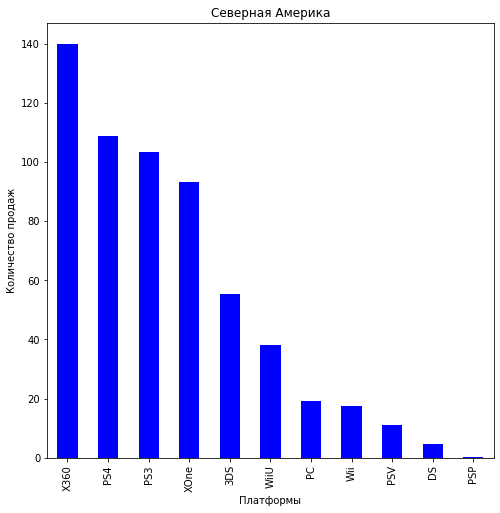

In [ ]:
(report_true_user_proba['na_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Северная Америка', color='b')
)
plt.xlabel('Платформы')
plt.ylabel('Количество продаж')
plt.show()

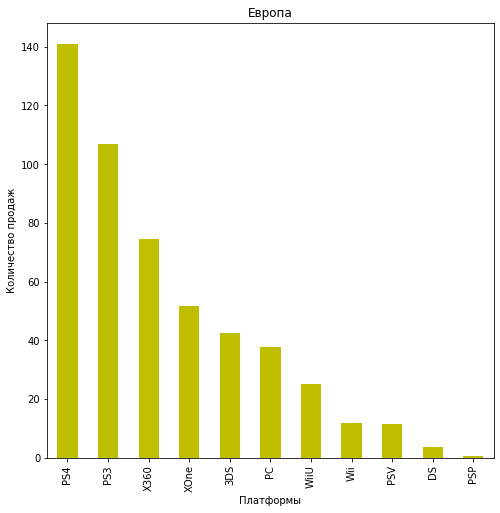

In [ ]:
(report_true_user_proba['eu_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Европа', color='y')
)
plt.xlabel('Платформы')
plt.ylabel('Количество продаж')
plt.show()

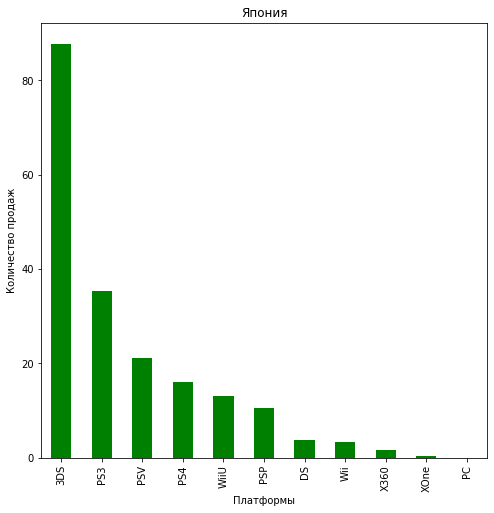

In [ ]:
(report_true_user_proba['jp_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Япония', color='g')
)
plt.xlabel('Платформы')
plt.ylabel('Количество продаж')
plt.show()

**Самые популярные платформы по регионам:**
- **Северная Америка** - доля продаж **X360** составляет **23.7%,**
- **Европа** - доля продаж **PS4** составляет **27.8%,**
- **Япония** - доля продаж **3DS** составляет **45.6%.**

#### Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5).

In [ ]:
report_genre = report_true.groupby('genre')

In [ ]:
report_genre = report_genre['na_sales', 'eu_sales', 'jp_sales'].sum()

Вычислим доли продаж для каждого жанра по регионам, максимальные значения выделим зеленым цветом:

In [ ]:
(report_genre.div(report_genre.sum(axis=0), axis=1)
.style
.highlight_max(color='yellowgreen')
)

,na_sales,eu_sales,jp_sales
genre,,,
Action,0.300929,0.314392,0.274172
Adventure,0.0150938,0.0186654,0.0427874
Fighting,0.0334873,0.0212896,0.0490186
Misc,0.0646226,0.0519317,0.0667774
Platform,0.0429463,0.0422438,0.0448125
Puzzle,0.00191211,0.00276232,0.0111123
Racing,0.0291385,0.0538455,0.0129816
Role-Playing,0.108297,0.0957539,0.339807
Shooter,0.24497,0.223886,0.0479281


Построим и изучим диаграммы распределения продаж по жанрам и регионам:

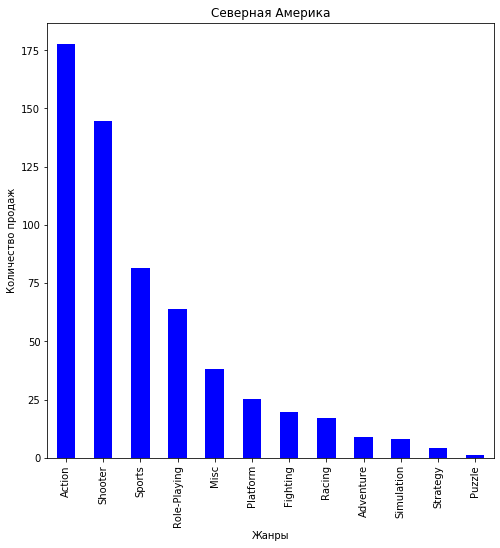

In [ ]:
(report_genre['na_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Северная Америка', color='b')
)
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.show()

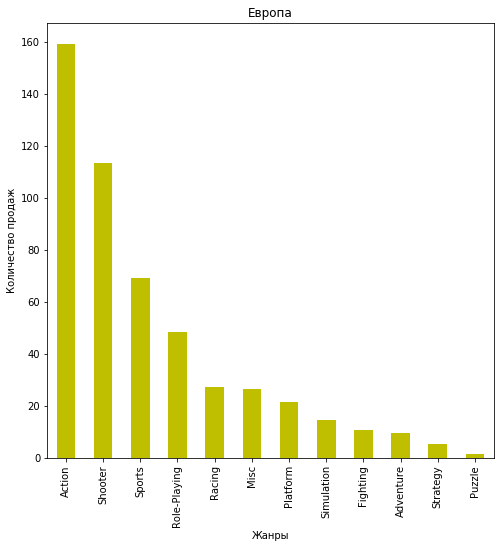

In [ ]:
(report_genre['eu_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Европа', color='y')
)
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.show()

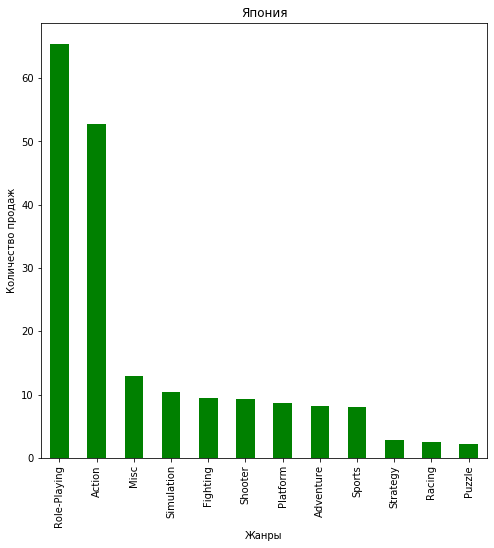

In [ ]:
(report_genre['jp_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Япония', color='g')
)
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.show()

**Самые популярные жанры по регионам:**

**Северная Америка** - доля продаж Action составляет **30%**,
**Европа** - доля продаж Action составляет **31.4%**,
**Япония** - доля продаж Role-Playing составляет **34%**.

#### Изучим влияние рейтинга ESRB на продажи в отдельном регионе

In [ ]:
report_true_esrb = report_true.groupby('rating')

In [ ]:
report_true_esrb['rating'].value_counts()

rating   rating 
E        E           395
E10+     E10+        306
M        M           498
T        T           412
unknown  unknown    1275
Name: rating, dtype: int64

In [ ]:
esrb_rate = report_true_esrb['na_sales', 'eu_sales', 'jp_sales'].sum()

Вычислим доли продаж для каждого рейтинга по регионам, максимальные значения выделим зеленым цветом:

In [ ]:
(esrb_rate
.div(esrb_rate.sum(axis=0), axis=1)
.style
.highlight_max(color='yellowgreen')
)

,na_sales,eu_sales,jp_sales
rating,,,
E,0.193529,0.223018,0.147108
E10+,0.128094,0.10925,0.0425278
M,0.391847,0.3827,0.110084
T,0.111715,0.104495,0.135113
unknown,0.174814,0.180537,0.565168


<div class="alert alert-info" role="alert">
Построим и изучим диаграммы:
</div>

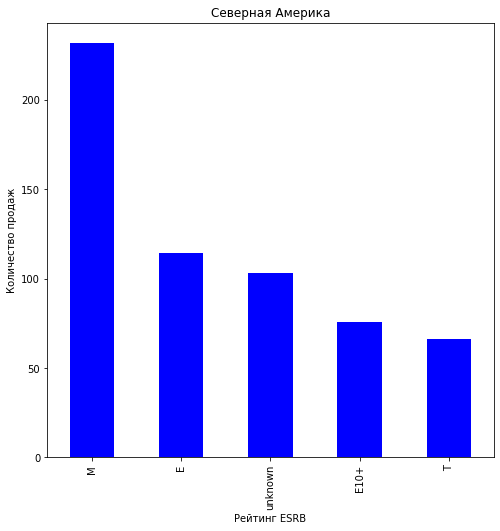

In [ ]:
(esrb_rate['na_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Северная Америка', color='b')
)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество продаж')
plt.show()

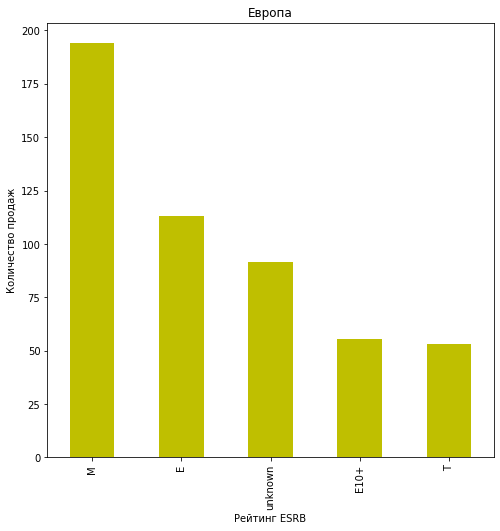

In [ ]:
(esrb_rate['eu_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Европа', color='y')
)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество продаж')
plt.show()

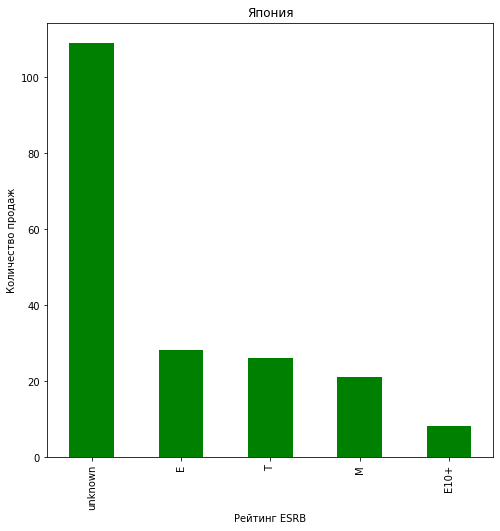

In [ ]:
(esrb_rate['jp_sales']
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(8,8), title='Япония', color='g')
)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество продаж')
plt.show()

Максимальные продажи в регионах **Северная Америка и Европа** приходятся на возрастной рейтинг **от 17 лет.**  

В регионе **Япония** - основные продажи приходятся на видеоигры с пропущенными значениями рейтинга.

### Вывод

**Самые популярные платформы по регионам:**
- **Северная Америка** - доля продаж **X360** составляет **23.7%,**
- **Европа** - доля продаж **PS4** составляет **27.8%,**
- **Япония** - доля продаж **3DS** составляет **45.6%.**  

**Самые популярные жанры по регионам:**

- **Северная Америка** - доля продаж **Action** составляет **30%**,
- **Европа** - доля продаж **Action** составляет **31.4%**,
- **Япония** - доля продаж **Role-Playing** составляет **34%**.

Максимальные продажи в регионах **Северная Америка и Европа** приходятся на возрастной рейтинг **от 17 лет.**  

В регионе **Япония** - основные продажи приходятся на видеоигры с пропущенными значениями рейтинга. Это может быть связано с тем, что игры не проходили международную классификацию по рейтингу ESRB.

## Шаг 5. Проверьте гипотезы

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.  
Задайте самостоятельно пороговое значение alpha.  
Поясните:  
- Как вы сформулировали нулевую и альтернативную гипотезы;  
- Какой критерий применили для проверки гипотез и почему.

#### Гипотеза №1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сделаем срезы для выделения платформ Xbox One и PC:

In [ ]:
x_one_test = report_true[report_true['platform'] == 'XOne']['user_score'].dropna()

In [ ]:
pc_test = report_true[report_true['platform'] == 'PC']['user_score'].dropna()

Рассчитаем дисперсию для установки верного параметра ***equal_var*** при проведении теста:

In [ ]:
var_x_one_test = np.var(x_one_test)

In [ ]:
var_pc_test = np.var(pc_test)

In [ ]:
(var_x_one_test, var_pc_test)

(1.8965188383045526, 2.7569952398906588)

In [ ]:
if (abs((var_x_one_test/var_pc_test)-1) < 0.05):
    print('equal_var = True')
else:
    print('equal_var = False')

equal_var = False


Дисперсии выборок отличаются больше, чем на 5% следовательно параметр ***equal_var = False.***

Проведем T-тест, и вычисилим вероятность того, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [ ]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    x_one_test, 
    pc_test, equal_var = False)

print('p-значение: {}'.format(results.pvalue))

p-значение: 0.5489537965134912


In [ ]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Не получилось отвергнуть нулевую гипотезу


В этом эксперименте мы не смогли отвергнуть нулевую гипотезу о равенстве двух выборок, т.к. p-value находится в рамках доверительного интервала. Следовательно можно сказать, что средние пользовательские рейтинги платформ Xbox One и PC - вероятней одинаковы.

In [ ]:
print('Средние пользовательские рейтинги платформ Xbox One {:.2f}'.format(x_one_test.mean()))
print('Средние пользовательские рейтинги платформ PC {:.2f}'.format(pc_test.mean()))

Средние пользовательские рейтинги платформ Xbox One 6.52
Средние пользовательские рейтинги платформ PC 6.43


Посмотрим на гистограммы пользовательских рейтингов платформ Xbox One и PC:

In [ ]:
test = (report_true
        .query('platform == "XOne" or platform == "PC"')
        .groupby('platform')
)

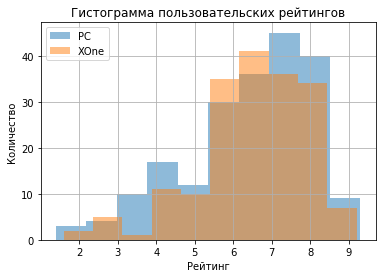

In [ ]:
test['user_score'].plot(kind='hist', bins=10, alpha=0.5, grid=True, title='Гистограмма пользовательских рейтингов', legend=True)
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()

Действительно, распределение значений пользовательских рейтингов платформ Xbox One и PC очень похожи.

#### Гипотеза №2. Средние пользовательские рейтинги жанров Action и Sports разные

Сделаем срезы для выделения пользовательских рейтингов жанров Action и Sports:

In [ ]:
action_test = report_true[report_true['genre'] == 'Action']['user_score'].dropna()

In [ ]:
sports_test = report_true[report_true['genre'] == 'Sports']['user_score'].dropna()

Как и в первой гипотезе, рассчитаем дисперсию для установки верного параметра ***equal_var*** при проведении теста:

In [ ]:
var_action_test = np.var(action_test)

In [ ]:
var_sports_test = np.var(sports_test)

In [ ]:
(var_action_test, var_sports_test)

(1.8854720340439224, 3.0073882971729127)

In [ ]:
if (abs((var_action_test/var_sports_test)-1) < 0.05):
    print('equal_var = True')
else:
    print('equal_var = False')

equal_var = False


Дисперсии выборок отличаются больше, чем на 5% следовательно параметр ***equal_var = False.***

Проведем T-тест, и вычисилим вероятность того, что cредние пользовательские рейтинги жанров Action и Sports разные:

In [ ]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    action_test, 
    sports_test, equal_var = False)

print('p-значение: {}'.format(results.pvalue))

p-значение: 4.24307776572644e-20


In [ ]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


В этом эксперименте мы с уверенность можем отвергнуть нулевую гипотезу о равенстве двух выборок, т.к. p-value находится за пределами критического уровеня статистической значимости. Следовательно можно сказать, что средние пользовательские рейтинги жанров Action и Sports  - разные.

In [ ]:
print('Средние пользовательские рейтинги жанров Action {:.2f}'.format(action_test.mean()))
print('Средние пользовательские рейтинги жанров Sports {:.2f}'.format(sports_test.mean()))

Средние пользовательские рейтинги жанров Action 6.83
Средние пользовательские рейтинги жанров Sports 5.46


In [ ]:
test2 = (report_true
        .query('genre == "Action" or genre == "Sports"')
        .groupby('genre')
)

Посмотрим на гистограммы пользовательских рейтингов жанров Action и Sports:

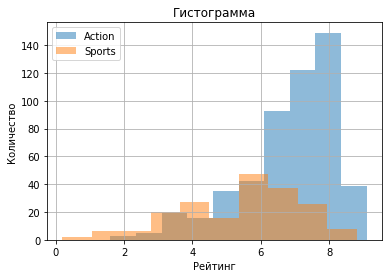

In [ ]:
test2['user_score'].plot(kind='hist', bins=10, alpha=0.5, grid=True, title='Гистограмма', legend=True)
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()

Как видно на гистограмме пользовательских рейтингов жанров Action и Sports отличаются. В жанре Action пользователи ставят больше высоких оценок, чем в жанре Sports.

#### Формулировки нулевой и альтернативной гипотезы:

##### Формулировки гипотезы №1

H0 - Средние пользовательские рейтинги платформ Xbox One и PC ***одинаковы***

Н1 - Средние пользовательские рейтинги платформ Xbox One и PC ***различны***

##### Формулировки гипотезы №2

H0 - Средние пользовательские рейтинги жанров Action и Sports ***одинаковы***

Н1 - Средние пользовательские рейтинги жанров Action и Sports ***различны***

#### Какой критерий применили для проверки гипотез и почему

В данных экспериментах мы использовали T-критерий Стьюдента для количественной оценки разницы между средним двух независимых выборок данных.

## Шаг 6. Напишите общий вывод

Для анализа предоставлена одна таблица состоящая из 16715 строк и 11 колонок.

Присутствуют пропуски в 5 столбцах: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating.

Дубликаты отсутствуют.  

**Возможные причины появления пропусков:**

- отсутствие или недавний релиз игры;
- отсутствие сведений в источнике сбора данных;
- маленькие продажи игр с пропущенными значениями;
- узкая аудитория выпущенной игры;
- отсутствие интереса критиков к написанию рецензии из-за низкого спроса.  


В 1994 год количество выпущенных игр за год перевалило за 100 релизов и росло с каждым годом до 2009 года включительно. С 2010 количество выпущенных игр падает с каждым годом.

В среднем жизненный цикл игровых платформ составляет **6 лет**. Для анализа были взяты данные за период с 2012 года по 2016.
Количество выпущенных новых игр увеличивается только на двух платформах PS4 и XOne, на остальных платформах наблюдается снижение продаж.

На платформах PS3, X360, XOne, 3DS в среднем продается около **40 млн** копий игр в год.
Платформа PS4 получилась очень удачной по сравнению с PS3, средние продажи по ней в год составляют более **80 млн** копий.

Сумма продаж в большей степени коррелируется с оценками критиков, чем пользователей.

Пользователи и критики оценивают игры в целом одинаково. **Средняя оценка критиков 70, пользователей 6,5**.  
Средний рейтинг критиков на все платформах из ТОП-5 примерно одинаковый и равен **70.**
Средняя оценка пользователей находится в пределах от **6.4 до 6,8** для четырех платформ (PS3, PS4, X360, XOne).
Для платформы 3DS среднее значение оценок пользователей выше и равна **7,2**.  

**ТОП - 4 жанра:**

- Жанр **Action** - **лидирует** по количеству релизов и продажам.  
- Жанр **Shooter** - по продажам на **втором месте**, но уступает в количесвте релизов жанрам Role-Playing, Adventure, Sports. 
- Жанр **Role-Playing** - по продажам на **третьем месте**, а по количеству релизов на втором.  
- Жанр **Sports** - по продажам и релизам на **четвертом месте**.  

**Самые популярные платформы по регионам:**
- **Северная Америка** - доля продаж **X360** составляет **23.7%,**
- **Европа** - доля продаж **PS4** составляет **27.8%,**
- **Япония** - доля продаж **3DS** составляет **45.6%.**  

**Самые популярные жанры по регионам:**

- **Северная Америка** - доля продаж **Action** составляет **30%**,
- **Европа** - доля продаж **Action** составляет **31.4%**,
- **Япония** - доля продаж **Role-Playing** составляет **34%**.

Максимальные продажи в регионах **Северная Америка и Европа** приходятся на возрастной рейтинг ESRB **«M» («Mature»)  "от 17 лет."**  

В регионе **Япония** - основные продажи приходятся на видеоигры с пропущенными значениями рейтинга. Это может быть связано с тем, что игры не проходили международную классификацию по рейтингу ESRB.   


**Результаты проверки гипотез:**
- Средние пользовательские рейтинги платформ Xbox One и PC - вероятней одинаковы.  
- Средние пользовательские рейтинги жанров Action и Sports - разные.


**Рекомендации:**

**1) Для региона Северная Америка** самая популярная платформа **X360 и Xbox One**, в 2017 году ожидается рост продаж для **Xbox One** и падение по  X360, из-за увеличения/уменьшения релизов видеоигр.  Реклмную кампанию необходимо планировать на эти платформы и учитывать, что основные продажи придутся на жанр **Action**.

**2) Для региона Европа** самая популярная платформа **Play Station 4**, основные продажи придутся именно на нее в жанре **Action**. Рекламная кампанию на 2017 год требуется планировать исходя из этих данных.

**3) Для региона Япония** самая популярная платформа **Nintendo 3DS**. Практически половина продаж приходится на эту платформу. Основной жанр в продажах - **Role-Playing**. При проведении рекламной кампании требуется сделать максимальный акцент на портативную платформу **Nintendo 3DS** и жанр **Role-Playing**.

**4)** Учесть, что у многих игр даже с низкими рейтингами критиков, есть любящие **фанаты** максимально прощающие огрехи при создании видеоигры.

**5)** Следить за датами выхода игр и планировать рекламные кампании для платформы **Play Station 4**, т.к. она является лидером по мировым продажам видеоигр.

